# Automated Timetable Generation for FSTM
## Hybrid Genetic Algorithm with Simulated Annealing

**Module:** Metaheuristics - Master in Artificial Intelligence  
**Authors:** Youssef Ait Bahssine, Mustapha Zmirli, Mohamed Bajadi  
**Date:** January 2026

---

## Abstract

This project addresses the University Course Timetabling Problem (UCTP) at the Faculty of Sciences and Techniques of Marrakech (FSTM). We implement a hybrid metaheuristic approach combining Genetic Algorithm (GA) for global exploration and Simulated Annealing (SA) for local refinement. The algorithm successfully optimizes the assignment of 228 sessions across 34 rooms and 30 time slots while respecting hard constraints (teacher conflicts, room capacity, group conflicts) and minimizing soft constraints (schedule gaps, time penalties, load balancing).

**Key Results:**
- 99.9% reduction in total fitness score
- All hard constraints satisfied (feasible solution)
- 88.2% improvement in soft constraint quality
- Schedule gaps reduced by 72.73% through targeted optimization
- Computational time: under 2 minutes

---

## Table of Contents

1. [Problem Formulation](#1)
2. [Data Loading and Preprocessing](#2)
3. [Solution Representation](#3)
4. [Constraint Functions](#4)
5. [Genetic Algorithm Implementation](#5)
6. [Simulated Annealing Implementation](#6)
7. [Hybrid GA+SA Algorithm](#7)
8. [Experimental Results](#8)
9. [Detailed Constraint Analysis](#9)
10. [Advanced Soft Constraint Optimization](#10)
11. [Timetable Generation](#11)
12. [Visualization and Analysis](#12)
13. [Conclusions](#13)

---

<a id='1'></a>
## 1. Problem Formulation

### 1.1 Problem Definition

The University Course Timetabling Problem involves assigning a set of events (courses and tutorials) to time slots and rooms while satisfying institutional requirements.

**Entities:**
- 228 sessions to schedule
- 34 rooms (4 amphitheaters, 30 classrooms)
- 30 time slots (6 days × 5 time periods)
- 44 teachers
- 22 student groups

### 1.2 Constraints

**Hard Constraints (must be satisfied):**
1. No teacher conflict: A teacher cannot teach multiple sessions simultaneously
2. No room conflict: A room cannot host multiple sessions simultaneously
3. No group conflict: A student group cannot attend multiple sessions simultaneously
4. Room capacity: Assigned room must accommodate all students
5. Room type: Sessions must be assigned to appropriate room types

**Soft Constraints (should be minimized):**
1. Schedule gaps: Minimize idle time between sessions for groups and teachers
2. Time penalties: Avoid early morning (08:30) and late afternoon (16:30) slots
3. Load balancing: Distribute sessions evenly across days

### 1.3 Objective Function

The fitness function is defined as:

$$f(S) = w_H \times \sum_{i=1}^{5} H_i(S) + w_S \times \sum_{j=1}^{3} S_j(S)$$

Where:
- $w_H = 1,000,000$ (hard constraint weight)
- $w_S = 1$ (soft constraint weight)
- $H_i$ are hard constraint violations
- $S_j$ are soft constraint penalties

The goal is to minimize $f(S)$, ideally reaching $f(S) = 0$ (perfect solution).

<a id='2'></a>
## 2. Data Loading and Preprocessing

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import random
import copy
import math
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully")
print(f"Random seed: {RANDOM_SEED}")

Libraries imported successfully
Random seed: 42


In [2]:
# Load datasets
DATA_PATH = '../data/processed/'

rooms_df = pd.read_csv(f'{DATA_PATH}rooms.csv')
groups_df = pd.read_csv(f'{DATA_PATH}groups.csv')
teachers_df = pd.read_csv(f'{DATA_PATH}teachers.csv')
courses_df = pd.read_csv(f'{DATA_PATH}courses.csv')
sessions_df = pd.read_csv(f'{DATA_PATH}sessions.csv')
assignments_df = pd.read_csv(f'{DATA_PATH}assignments.csv')
slot_penalties_df = pd.read_csv(f'{DATA_PATH}slot_penalties.csv')

print("Dataset Summary:")
print(f"  Rooms: {len(rooms_df)}")
print(f"  Groups: {len(groups_df)}")
print(f"  Teachers: {len(teachers_df)}")
print(f"  Assignments: {len(assignments_df)}")
print(f"  Time slots: {len(slot_penalties_df)}")

Dataset Summary:
  Rooms: 34
  Groups: 40
  Teachers: 134
  Assignments: 183
  Time slots: 5


In [3]:
# Preprocess: Create time slot structure
day_mapping = {'LUNDI': 1, 'MARDI': 2, 'MERCREDI': 3, 'JEUDI': 4, 'VENDREDI': 5, 'SAMEDI': 6}
time_slots = sorted(slot_penalties_df['start_time'].unique())
time_slot_mapping = {time: i+1 for i, time in enumerate(time_slots)}

# Create comprehensive slot list
slot_list = []
slot_id = 1
for day_name, day_num in day_mapping.items():
    for time_slot in time_slots:
        penalty = slot_penalties_df[slot_penalties_df['start_time']==time_slot]['penalty'].values[0] \
                  if len(slot_penalties_df[slot_penalties_df['start_time']==time_slot]) > 0 else 0
        slot_list.append({
            'slot_id': slot_id,
            'day': day_num,
            'day_name': day_name,
            'start_time': time_slot,
            'penalty': penalty
        })
        slot_id += 1

slots_df = pd.DataFrame(slot_list)

# Extract individual sessions from assignments
session_list = []
for idx, row in assignments_df.iterrows():
    groups = row['involved_groups'].split(';') if pd.notna(row['involved_groups']) else []
    for group in groups:
        session_list.append({
            'session_id': len(session_list),
            'session_name': row['session_name'],
            'session_type': row['session_type'],
            'teacher_id': row['teacher_id'],
            'group_name': group.strip()
        })

extracted_sessions_df = pd.DataFrame(session_list)
group_size_map = dict(zip(groups_df['group_name'], groups_df['size']))

print(f"\nPreprocessing complete:")
print(f"  Created {len(slots_df)} time slots")
print(f"  Extracted {len(extracted_sessions_df)} individual sessions")


Preprocessing complete:
  Created 30 time slots
  Extracted 228 individual sessions


<a id='3'></a>
## 3. Solution Representation

### 3.1 Chromosome Encoding

A solution (chromosome) is represented as a list of assignments:
- Each gene corresponds to one session
- Gene value: (slot_id, room_id)
- Length: 228 sessions

**Example:**
```python
chromosome = [
    (5, 'A1'),    # Session 0: Monday 10:30 in Amphitheater 1
    (12, 'S 24'), # Session 1: Tuesday 14:30 in Classroom S 24
    ...
]
```

In [4]:
class TimetableGA:
    """Genetic Algorithm system for university timetabling"""
    
    def __init__(self, sessions_df, rooms_df, groups_df, slots_df, group_size_map):
        self.sessions = sessions_df.to_dict('records')
        self.rooms = rooms_df.to_dict('records')
        self.slots = slots_df.to_dict('records')
        self.group_size_map = group_size_map
        
        self.room_dict = {r['room_id']: r for r in self.rooms}
        self.slot_dict = {s['slot_id']: s for s in self.slots}
        self.slot_penalties = {s['slot_id']: s['penalty'] for s in self.slots}
        
        self.room_ids = [r['room_id'] for r in self.rooms]
        self.slot_ids = [s['slot_id'] for s in self.slots]
        
        print(f"GA System initialized:")
        print(f"  Sessions: {len(self.sessions)}")
        print(f"  Rooms: {len(self.rooms)}")
        print(f"  Time slots: {len(self.slots)}")
    
    def create_chromosome(self):
        """Generate random solution"""
        chromosome = []
        for session in self.sessions:
            slot = random.choice(self.slot_ids)
            room = random.choice(self.room_ids)
            chromosome.append((slot, room))
        return chromosome
    
    def create_greedy_chromosome(self):
        """Generate solution using greedy heuristic"""
        chromosome = []
        room_usage = defaultdict(int)
        
        for session in self.sessions:
            group_size = self.group_size_map.get(session['group_name'], 30)
            
            # Select suitable room with lowest usage
            suitable_rooms = [
                r for r in self.room_ids 
                if self.room_dict[r]['capacity'] >= group_size
            ]
            
            if suitable_rooms:
                suitable_rooms.sort(key=lambda r: room_usage[r])
                room = suitable_rooms[0]
            else:
                room = random.choice(self.room_ids)
            
            # Prefer slots with low penalties
            slot = random.choice([s for s in self.slot_ids if self.slot_penalties[s] == 0] or self.slot_ids)
            
            chromosome.append((slot, room))
            room_usage[room] += 1
        
        return chromosome

# Initialize GA system
ga_system = TimetableGA(extracted_sessions_df, rooms_df, groups_df, slots_df, group_size_map)

GA System initialized:
  Sessions: 228
  Rooms: 34
  Time slots: 30


<a id='4'></a>
## 4. Constraint Functions

Implementation of all constraint checking functions.

In [5]:
class ConstraintChecker:
    """Evaluates solution quality based on constraints"""
    
    def __init__(self, ga_system):
        self.ga = ga_system
        self.HARD_WEIGHT = 1_000_000
        self.SOFT_WEIGHT = 1
    
    def check_teacher_conflicts(self, chromosome):
        """Count teacher conflicts (H1)"""
        conflicts = 0
        teacher_schedule = defaultdict(list)
        
        for i, (slot, room) in enumerate(chromosome):
            teacher_id = self.ga.sessions[i]['teacher_id']
            if teacher_id:
                teacher_schedule[teacher_id].append(slot)
        
        for teacher, slots in teacher_schedule.items():
            slot_counts = Counter(slots)
            for slot, count in slot_counts.items():
                if count > 1:
                    conflicts += (count - 1)
        
        return conflicts
    
    def check_room_conflicts(self, chromosome):
        """Count room conflicts (H2)"""
        conflicts = 0
        room_schedule = defaultdict(list)
        
        for i, (slot, room) in enumerate(chromosome):
            room_schedule[(slot, room)].append(i)
        
        for key, sessions in room_schedule.items():
            if len(sessions) > 1:
                conflicts += (len(sessions) - 1)
        
        return conflicts
    
    def check_group_conflicts(self, chromosome):
        """Count group conflicts (H3)"""
        conflicts = 0
        group_schedule = defaultdict(list)
        
        for i, (slot, room) in enumerate(chromosome):
            group_name = self.ga.sessions[i]['group_name']
            if group_name:
                group_schedule[(slot, group_name)].append(i)
        
        for key, sessions in group_schedule.items():
            if len(sessions) > 1:
                conflicts += (len(sessions) - 1)
        
        return conflicts
    
    def check_capacity_violations(self, chromosome):
        """Count capacity violations (H4)"""
        violations = 0
        
        for i, (slot, room) in enumerate(chromosome):
            group_name = self.ga.sessions[i]['group_name']
            group_size = self.ga.group_size_map.get(group_name, 30)
            room_capacity = self.ga.room_dict[room]['capacity']
            
            if group_size > room_capacity:
                violations += 1
        
        return violations
    
    def check_room_type_violations(self, chromosome):
        """Count room type violations (H5)"""
        violations = 0
        
        for i, (slot, room) in enumerate(chromosome):
            session_type = self.ga.sessions[i]['session_type']
            group_size = self.ga.group_size_map.get(self.ga.sessions[i]['group_name'], 30)
            room_type = self.ga.room_dict[room]['type']
            
            # Large courses (>100 students) should use amphitheaters
            if session_type == 'Cours' and group_size > 100 and room_type != 'Amphitheater':
                violations += 1
        
        return violations
    
    def calculate_schedule_gaps(self, chromosome):
        """Calculate schedule gaps (S1)"""
        gaps = 0
        
        # Group gaps
        group_schedules = defaultdict(lambda: defaultdict(list))
        for i, (slot, room) in enumerate(chromosome):
            group_name = self.ga.sessions[i]['group_name']
            day_name = self.ga.slot_dict[slot]['day_name']
            time_idx = self.ga.slot_dict[slot]['slot_id'] % 5
            group_schedules[group_name][day_name].append(time_idx)
        
        for group, days in group_schedules.items():
            for day, times in days.items():
                if len(times) > 1:
                    times_sorted = sorted(times)
                    span = times_sorted[-1] - times_sorted[0] + 1
                    gaps += (span - len(times))
        
        # Teacher gaps
        teacher_schedules = defaultdict(lambda: defaultdict(list))
        for i, (slot, room) in enumerate(chromosome):
            teacher_id = self.ga.sessions[i]['teacher_id']
            day_name = self.ga.slot_dict[slot]['day_name']
            time_idx = self.ga.slot_dict[slot]['slot_id'] % 5
            teacher_schedules[teacher_id][day_name].append(time_idx)
        
        for teacher, days in teacher_schedules.items():
            for day, times in days.items():
                if len(times) > 1:
                    times_sorted = sorted(times)
                    span = times_sorted[-1] - times_sorted[0] + 1
                    gaps += (span - len(times))
        
        return gaps
    
    def calculate_time_penalties(self, chromosome):
        """Calculate time slot penalties (S2)"""
        penalty = sum([self.ga.slot_penalties[slot] for slot, room in chromosome])
        return penalty
    
    def calculate_load_balance(self, chromosome):
        """Calculate load balancing penalty (S3)"""
        day_counts = defaultdict(int)
        
        for slot, room in chromosome:
            day_name = self.ga.slot_dict[slot]['day_name']
            day_counts[day_name] += 1
        
        counts = list(day_counts.values())
        if len(counts) > 1:
            return np.var(counts)
        return 0
    
    def calculate_fitness(self, chromosome):
        """Calculate total fitness (lower is better)"""
        # Hard constraints
        h1 = self.check_teacher_conflicts(chromosome)
        h2 = self.check_room_conflicts(chromosome)
        h3 = self.check_group_conflicts(chromosome)
        h4 = self.check_capacity_violations(chromosome)
        h5 = self.check_room_type_violations(chromosome)
        total_hard = h1 + h2 + h3 + h4 + h5
        
        # Soft constraints
        s1 = self.calculate_schedule_gaps(chromosome)
        s2 = self.calculate_time_penalties(chromosome)
        s3 = self.calculate_load_balance(chromosome)
        total_soft = s1 + s2 + s3
        
        fitness = self.HARD_WEIGHT * total_hard + self.SOFT_WEIGHT * total_soft
        
        return fitness, total_hard, total_soft

# Initialize constraint checker
checker = ConstraintChecker(ga_system)
print("Constraint checker initialized")

Constraint checker initialized


<a id='5'></a>
## 5. Genetic Algorithm Implementation

### 5.1 GA Parameters

- Population size: 100
- Generations: 300
- Crossover rate: 0.8 (uniform crossover)
- Mutation rate: 0.15
- Selection: Tournament (size 5)
- Elitism: Top 10 preserved

In [6]:
class GeneticAlgorithm:
    """Genetic Algorithm for timetable optimization"""
    
    def __init__(self, ga_system, checker, pop_size=100, generations=300, 
                 crossover_rate=0.8, mutation_rate=0.15, elitism=10):
        self.ga = ga_system
        self.checker = checker
        self.pop_size = pop_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elitism = elitism
    
    def initialize_population(self):
        """Create initial population with diverse strategies"""
        population = []
        
        # 50% random
        for _ in range(self.pop_size // 2):
            population.append(self.ga.create_chromosome())
        
        # 50% greedy
        for _ in range(self.pop_size - len(population)):
            population.append(self.ga.create_greedy_chromosome())
        
        return population
    
    def tournament_selection(self, population, fitnesses, tournament_size=5):
        """Select parent using tournament selection"""
        tournament = random.sample(range(len(population)), min(tournament_size, len(population)))
        best_idx = min(tournament, key=lambda i: fitnesses[i])
        return population[best_idx]
    
    def crossover(self, parent1, parent2):
        """Uniform crossover"""
        if random.random() > self.crossover_rate:
            return parent1.copy(), parent2.copy()
        
        child1, child2 = [], []
        for i in range(len(parent1)):
            if random.random() < 0.5:
                child1.append(parent1[i])
                child2.append(parent2[i])
            else:
                child1.append(parent2[i])
                child2.append(parent1[i])
        
        return child1, child2
    
    def mutate(self, chromosome):
        """Apply mutation operators"""
        mutated = chromosome.copy()
        
        for i in range(len(mutated)):
            if random.random() < self.mutation_rate:
                # Random mutation type
                mutation_type = random.choice(['slot', 'room', 'both'])
                
                if mutation_type == 'slot':
                    mutated[i] = (random.choice(self.ga.slot_ids), mutated[i][1])
                elif mutation_type == 'room':
                    mutated[i] = (mutated[i][0], random.choice(self.ga.room_ids))
                else:
                    mutated[i] = (random.choice(self.ga.slot_ids), random.choice(self.ga.room_ids))
        
        return mutated
    
    def evolve(self, verbose=True):
        """Main evolution loop"""
        if verbose:
            print("\nGenetic Algorithm Evolution")
            print("=" * 70)
            print(f"Population: {self.pop_size}, Generations: {self.generations}")
            print(f"Crossover: {self.crossover_rate}, Mutation: {self.mutation_rate}")
            print("\nInitializing population...")
        
        population = self.initialize_population()
        history = []
        best_ever = None
        best_fitness_ever = float('inf')
        
        start_time = time.time()
        
        for gen in range(self.generations):
            # Evaluate fitness
            fitness_data = [self.checker.calculate_fitness(ind) for ind in population]
            fitnesses = [f[0] for f in fitness_data]
            
            # Track best
            best_idx = fitnesses.index(min(fitnesses))
            best_fitness, best_hard, best_soft = fitness_data[best_idx]
            
            if best_fitness < best_fitness_ever:
                best_ever = population[best_idx].copy()
                best_fitness_ever = best_fitness
            
            history.append(best_fitness)
            
            # Progress reporting
            if verbose and gen % 20 == 0:
                avg_fitness = np.mean(fitnesses)
                print(f"Gen {gen:3d}: Best={best_fitness:10.1f} "
                      f"(H={best_hard:3d}, S={best_soft:6.1f}) | Avg={avg_fitness:10.1f}")
            
            # Early stopping
            if best_fitness == 0:
                if verbose:
                    print(f"\nOptimal solution found at generation {gen}")
                break
            
            # Selection and reproduction
            offspring = []
            
            # Elitism
            elite_indices = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i])[:self.elitism]
            offspring.extend([population[i].copy() for i in elite_indices])
            
            # Generate offspring
            while len(offspring) < self.pop_size:
                parent1 = self.tournament_selection(population, fitnesses)
                parent2 = self.tournament_selection(population, fitnesses)
                
                child1, child2 = self.crossover(parent1, parent2)
                
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                
                offspring.extend([child1, child2])
            
            population = offspring[:self.pop_size]
        
        elapsed = time.time() - start_time
        
        if verbose:
            print("\n" + "=" * 70)
            print(f"Evolution complete in {elapsed:.2f} seconds")
            print(f"Best fitness: {best_fitness_ever:.1f}")
        
        return best_ever, history

print("Genetic Algorithm class defined")

Genetic Algorithm class defined


<a id='6'></a>
## 6. Simulated Annealing Implementation

### 6.1 SA Parameters

- Initial temperature: 1000
- Cooling rate: 0.95 (geometric cooling)
- Iterations per temperature: 100
- Acceptance criterion: Metropolis

In [7]:
class SimulatedAnnealingSA:
    """Simulated Annealing for local refinement"""
    
    def __init__(self, ga_system, checker):
        self.ga = ga_system
        self.checker = checker
    
    def get_neighbor(self, chromosome):
        """Generate neighbor solution"""
        neighbor = chromosome.copy()
        
        # Select random move type
        move_type = random.choice(['swap', 'move_slot', 'move_room', 'move_both'])
        
        if move_type == 'swap':
            # Swap two sessions
            i, j = random.sample(range(len(neighbor)), 2)
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        
        elif move_type == 'move_slot':
            # Change time slot for random session
            i = random.randint(0, len(neighbor) - 1)
            neighbor[i] = (random.choice(self.ga.slot_ids), neighbor[i][1])
        
        elif move_type == 'move_room':
            # Change room for random session
            i = random.randint(0, len(neighbor) - 1)
            neighbor[i] = (neighbor[i][0], random.choice(self.ga.room_ids))
        
        else:
            # Change both slot and room
            i = random.randint(0, len(neighbor) - 1)
            neighbor[i] = (random.choice(self.ga.slot_ids), random.choice(self.ga.room_ids))
        
        return neighbor
    
    def optimize(self, initial_solution, initial_temp=1000, cooling_rate=0.95, 
                 iterations=100, verbose=False):
        """Apply Simulated Annealing"""
        current = initial_solution.copy()
        current_fitness, _, _ = self.checker.calculate_fitness(current)
        initial_fitness = current_fitness
        
        best = current.copy()
        best_fitness = current_fitness
        
        temperature = initial_temp
        history = [current_fitness]
        
        iteration = 0
        
        while temperature > 0.1:
            for _ in range(iterations):
                # Generate neighbor
                neighbor = self.get_neighbor(current)
                neighbor_fitness, _, _ = self.checker.calculate_fitness(neighbor)
                
                # Calculate delta
                delta = neighbor_fitness - current_fitness
                
                # Acceptance criterion
                if delta < 0 or random.random() < math.exp(-delta / temperature):
                    current = neighbor
                    current_fitness = neighbor_fitness
                    
                    if current_fitness < best_fitness:
                        best = current.copy()
                        best_fitness = current_fitness
                
                history.append(current_fitness)
                iteration += 1
            
            # Cool down
            temperature *= cooling_rate
            
            if verbose and iteration % 1000 == 0:
                print(f"Iteration {iteration}: T={temperature:.2f}, Best={best_fitness:.1f}")
        
        if verbose:
            print(f"\nSA complete: {initial_fitness:.1f} -> {best_fitness:.1f}")
        
        return best, history

print("Simulated Annealing class defined")

Simulated Annealing class defined


<a id='7'></a>
## 7. Hybrid GA+SA Algorithm

The hybrid approach combines GA's global exploration with SA's local exploitation:

1. GA evolves population for broad search
2. SA refines best solution for local optimization
3. Result: Better convergence and solution quality

In [8]:
def hybrid_ga_sa(ga_system, checker, verbose=True):
    """Execute Hybrid GA+SA optimization"""
    
    if verbose:
        print("\n" + "=" * 80)
        print("HYBRID GA+SA OPTIMIZATION")
        print("=" * 80)
    
    # Phase 1: Genetic Algorithm
    if verbose:
        print("\nPhase 1: Genetic Algorithm")
    
    ga = GeneticAlgorithm(ga_system, checker, 
                          pop_size=100, 
                          generations=300, 
                          crossover_rate=0.8, 
                          mutation_rate=0.15,
                          elitism=10)
    
    ga_best, ga_history = ga.evolve(verbose=verbose)
    ga_fitness, ga_hard, ga_soft = checker.calculate_fitness(ga_best)
    
    # Phase 2: Simulated Annealing
    if verbose:
        print("\nPhase 2: Simulated Annealing Refinement")
        print("=" * 70)
    
    sa = SimulatedAnnealingSA(ga_system, checker)
    sa_best, sa_history = sa.optimize(ga_best, 
                                       initial_temp=1000, 
                                       cooling_rate=0.95, 
                                       iterations=100,
                                       verbose=verbose)
    
    sa_fitness, sa_hard, sa_soft = checker.calculate_fitness(sa_best)
    
    if verbose:
        print("\n" + "=" * 80)
        print("HYBRID RESULTS")
        print("=" * 80)
        print(f"GA Result:  Fitness={ga_fitness:.1f} (H={ga_hard}, S={ga_soft:.1f})")
        print(f"SA Result:  Fitness={sa_fitness:.1f} (H={sa_hard}, S={sa_soft:.1f})")
        print(f"Improvement: {((ga_fitness - sa_fitness) / ga_fitness * 100):.2f}%")
    
    return sa_best, ga_history, sa_history

print("Hybrid GA+SA function defined")

Hybrid GA+SA function defined


<a id='8'></a>
## 8. Experimental Results

Running the hybrid optimization algorithm.

In [9]:
# Evaluate baseline (current timetable)
print("Evaluating baseline schedule...")

# Normalize data types and formats for comparison
# Convert day and time to strings and strip whitespace for reliable matching
assignments_df['day'] = assignments_df['day'].astype(str).str.strip().str.upper()
assignments_df['start_time'] = assignments_df['start_time'].astype(str).str.strip()
slots_df['day_name'] = slots_df['day_name'].astype(str).str.strip().str.upper()
slots_df['start_time'] = slots_df['start_time'].astype(str).str.strip()

baseline_chromosome = []
no_match_count = 0
no_match_examples = []

for idx, row in assignments_df.iterrows():
    # Find matching slot
    day_val = str(row['day']).strip().upper()
    time_val = str(row['start_time']).strip()
    
    matching_slots = slots_df[
        (slots_df['day_name'] == day_val) & 
        (slots_df['start_time'] == time_val)
    ]
    
    if len(matching_slots) == 0:
        no_match_count += 1
        if len(no_match_examples) < 3:  # Store first 3 examples for debugging
            available_days = slots_df['day_name'].unique()
            available_times = slots_df['start_time'].unique()
            no_match_examples.append({
                'row_idx': idx,
                'day': day_val,
                'time': time_val,
                'available_days': list(available_days),
                'available_times': list(available_times)
            })
        continue  # Skip this assignment if no matching slot found
    
    slot_id = matching_slots['slot_id'].values[0]
    
    # Repeat for each involved group
    groups = row['involved_groups'].split(';') if pd.notna(row['involved_groups']) else []
    if len(groups) == 0:
        groups = [None]  # If no groups specified, create one entry
    
    for group in groups:
        if group and group.strip():  # Only add if group is not empty
            baseline_chromosome.append((slot_id, row['room_id']))
        elif len(groups) == 1 and not group:  # Only add if it's the only entry
            baseline_chromosome.append((slot_id, row['room_id']))

if no_match_count > 0:
    print(f"\nWarning: {no_match_count} assignments could not be matched to time slots.")
    if no_match_examples:
        print("\nFirst few unmatched examples:")
        for ex in no_match_examples:
            print(f"  Row {ex['row_idx']}: day='{ex['day']}', time='{ex['time']}'")
            print(f"    Available days in slots_df: {ex['available_days']}")
            print(f"    Available times in slots_df: {ex['available_times']}")

if len(baseline_chromosome) == 0:
    print("\nERROR: No valid assignments found to create baseline chromosome!")
    print("Please check the data format in assignments_df and slots_df.")
else:
    baseline_fitness, baseline_hard, baseline_soft = checker.calculate_fitness(baseline_chromosome)
    
    print(f"\nBaseline Schedule:")
    print(f"  Total Assignments: {len(baseline_chromosome)}")
    print(f"  Total Fitness: {baseline_fitness:,.1f}")
    print(f"  Hard Violations: {baseline_hard}")
    print(f"  Soft Violations: {baseline_soft:.1f}")

Evaluating baseline schedule...


First few unmatched examples:
  Row 182: day='SAMEDI', time='13:00'
    Available days in slots_df: ['LUNDI', 'MARDI', 'MERCREDI', 'JEUDI', 'VENDREDI', 'SAMEDI']
    Available times in slots_df: ['08:30', '10:30', '12:30', '14:30', '16:30']

Baseline Schedule:
  Total Assignments: 227
  Total Fitness: 157,001,215.5
  Hard Violations: 157
  Soft Violations: 1215.5


In [10]:
# Run hybrid optimization
optimized_solution, ga_history, sa_history = hybrid_ga_sa(ga_system, checker, verbose=True)


HYBRID GA+SA OPTIMIZATION

Phase 1: Genetic Algorithm

Genetic Algorithm Evolution
Population: 100, Generations: 300
Crossover: 0.8, Mutation: 0.15

Initializing population...
Gen   0: Best=78000015.3 (H= 78, S=  15.3) | Avg=111950365.7
Gen  20: Best=51000437.7 (H= 51, S= 437.7) | Avg=70550444.2
Gen  40: Best=44000552.7 (H= 44, S= 552.7) | Avg=65940526.5
Gen  60: Best=44000552.7 (H= 44, S= 552.7) | Avg=63630620.8
Gen  80: Best=41000717.3 (H= 41, S= 717.3) | Avg=62620668.8
Gen 100: Best=40000708.3 (H= 40, S= 708.3) | Avg=60270666.3
Gen 120: Best=38000660.3 (H= 38, S= 660.3) | Avg=58640672.6
Gen 140: Best=38000660.3 (H= 38, S= 660.3) | Avg=58870697.9
Gen 160: Best=38000660.3 (H= 38, S= 660.3) | Avg=59570700.9
Gen 180: Best=38000660.3 (H= 38, S= 660.3) | Avg=57910700.3
Gen 200: Best=38000660.3 (H= 38, S= 660.3) | Avg=58930704.0
Gen 220: Best=38000660.3 (H= 38, S= 660.3) | Avg=58770705.0
Gen 240: Best=38000660.3 (H= 38, S= 660.3) | Avg=57820699.5
Gen 260: Best=38000660.3 (H= 38, S= 660.3)

<a id='9'></a>
## 9. Detailed Constraint Analysis

Comprehensive evaluation of constraint violations comparing baseline and optimized solutions.


In [12]:
def analyze_constraints(chromosome, checker, label="Solution"):
    """Detailed constraint analysis"""
    analysis = {
        'label': label,
        'h1_teacher': checker.check_teacher_conflicts(chromosome),
        'h2_room': checker.check_room_conflicts(chromosome),
        'h3_group': checker.check_group_conflicts(chromosome),
        'h4_capacity': checker.check_capacity_violations(chromosome),
        'h5_room_type': checker.check_room_type_violations(chromosome),
        's1_gaps': checker.calculate_schedule_gaps(chromosome),
        's2_time': checker.calculate_time_penalties(chromosome),
        's3_balance': checker.calculate_load_balance(chromosome)
    }
    
    fitness, hard, soft = checker.calculate_fitness(chromosome)
    analysis['total_fitness'] = fitness
    analysis['total_hard'] = hard
    analysis['total_soft'] = soft
    
    return analysis

# Analyze all solutions
print("\n" + "=" * 80)
print("COMPREHENSIVE CONSTRAINT ANALYSIS")
print("=" * 80)

baseline_analysis = analyze_constraints(baseline_chromosome, checker, "Baseline")
final_analysis = analyze_constraints(final_solution, checker, "Optimized")

# Display comparison
print("\nHard Constraints:")
print("-" * 80)
print(f"{'Constraint':<30} {'Baseline':>15} {'Optimized':>15} {'Improvement':>15}")
print("-" * 80)

hard_constraints = [
    ('Teacher Conflicts', 'h1_teacher'),
    ('Room Conflicts', 'h2_room'),
    ('Group Conflicts', 'h3_group'),
    ('Capacity Violations', 'h4_capacity'),
    ('Room Type Violations', 'h5_room_type')
]

for name, key in hard_constraints:
    baseline_val = baseline_analysis[key]
    final_val = final_analysis[key]
    improvement = baseline_val - final_val
    print(f"{name:<30} {baseline_val:>15} {final_val:>15} {improvement:>15}")

print("-" * 80)
print(f"{'TOTAL HARD':30} {baseline_analysis['total_hard']:>15} "
      f"{final_analysis['total_hard']:>15} "
      f"{baseline_analysis['total_hard'] - final_analysis['total_hard']:>15}")

print("\n\nSoft Constraints:")
print("-" * 80)
print(f"{'Constraint':<30} {'Baseline':>15} {'Optimized':>15} {'Improvement':>15}")
print("-" * 80)

soft_constraints = [
    ('Schedule Gaps', 's1_gaps'),
    ('Time Penalties', 's2_time'),
    ('Load Balance', 's3_balance')
]

for name, key in soft_constraints:
    baseline_val = baseline_analysis[key]
    final_val = final_analysis[key]
    improvement = baseline_val - final_val
    print(f"{name:<30} {baseline_val:>15.1f} {final_val:>15.1f} {improvement:>15.1f}")

print("-" * 80)
print(f"{'TOTAL SOFT':30} {baseline_analysis['total_soft']:>15.1f} "
      f"{final_analysis['total_soft']:>15.1f} "
      f"{baseline_analysis['total_soft'] - final_analysis['total_soft']:>15.1f}")

print("\n\nOverall Summary:")
print("=" * 80)
print(f"Baseline Fitness:  {baseline_analysis['total_fitness']:>15,.1f}")
print(f"Optimized Fitness: {final_analysis['total_fitness']:>15,.1f}")
print(f"Improvement:       {baseline_analysis['total_fitness'] - final_analysis['total_fitness']:>15,.1f} "
      f"({(1 - final_analysis['total_fitness']/baseline_analysis['total_fitness'])*100:.1f}%)")
print("="  * 80)

if final_analysis['total_hard'] == 0:
    print("\nRESULT: FEASIBLE SOLUTION (All hard constraints satisfied)")
else:
    print(f"\nWARNING: {final_analysis['total_hard']} hard violations remain")


COMPREHENSIVE CONSTRAINT ANALYSIS

Hard Constraints:
--------------------------------------------------------------------------------
Constraint                            Baseline       Optimized     Improvement
--------------------------------------------------------------------------------
Teacher Conflicts                           48               0              48
Room Conflicts                              45               0              45
Group Conflicts                             41               0              41
Capacity Violations                         21               0              21
Room Type Violations                         2               0               2
--------------------------------------------------------------------------------
TOTAL HARD                                 157               0             157


Soft Constraints:
--------------------------------------------------------------------------------
Constraint                            Baseline   

### 9.1 Results Interpretation

The initial hybrid GA+SA optimization successfully eliminated all hard constraint violations, achieving a feasible solution. However, schedule gaps increased from the baseline (1.0 to 11.0) as a trade-off for feasibility. The solution demonstrates excellent performance in time penalty reduction (87.6% improvement) and perfect load balancing.

**Key Observations:**
- All hard constraints satisfied: Critical requirement met
- Schedule gaps require further optimization
- Time penalties well-optimized from baseline
- Load balance achieved perfect distribution


<a id='10'></a>
## 10. Advanced Soft Constraint Optimization

Targeted optimization to further improve schedule gaps and time penalties while maintaining feasibility. Two specialized optimization functions are applied sequentially: gap reduction and penalty minimization.


In [18]:
# Advanced Soft Constraint Optimization
# Focus on reducing schedule gaps and time penalties

def optimize_schedule_gaps(chromosome, checker, ga_system, max_iterations=2000):
    """Optimize schedule gaps by intelligently moving sessions to fill gaps"""
    print("\n" + "=" * 70)
    print("OPTIMIZING SCHEDULE GAPS")
    print("=" * 70)
    
    current = chromosome.copy()
    current_fitness, current_hard, current_soft = checker.calculate_fitness(current)
    current_gaps = checker.calculate_schedule_gaps(current)
    
    print(f"Initial gaps: {current_gaps:.1f}")
    
    best = current.copy()
    best_gaps = current_gaps
    best_fitness = current_fitness
    
    # Identify groups/teachers with gaps
    group_schedules = defaultdict(lambda: defaultdict(list))
    teacher_schedules = defaultdict(lambda: defaultdict(list))
    
    for i, (slot, room) in enumerate(current):
        group_name = ga_system.sessions[i]['group_name']
        teacher_id = ga_system.sessions[i]['teacher_id']
        day_name = ga_system.slot_dict[slot]['day_name']
        time_idx = ga_system.slot_dict[slot]['slot_id'] % 5
        
        group_schedules[group_name][day_name].append((time_idx, i))
        if teacher_id:
            teacher_schedules[teacher_id][day_name].append((time_idx, i))
    
    # Find entities with gaps
    entities_with_gaps = []
    
    for group, days in group_schedules.items():
        for day, times in days.items():
            if len(times) > 1:
                times_sorted = sorted([t[0] for t in times])
                span = times_sorted[-1] - times_sorted[0] + 1
                if span > len(times):
                    entities_with_gaps.append(('group', group, day, times))
    
    for teacher, days in teacher_schedules.items():
        for day, times in days.items():
            if len(times) > 1:
                times_sorted = sorted([t[0] for t in times])
                span = times_sorted[-1] - times_sorted[0] + 1
                if span > len(times):
                    entities_with_gaps.append(('teacher', teacher, day, times))
    
    print(f"Found {len(entities_with_gaps)} entities with gaps")
    
    no_improvement = 0
    for iteration in range(max_iterations):
        if iteration % 500 == 0 and iteration > 0:
            print(f"Iteration {iteration}: Gaps={best_gaps:.1f}, Fitness={best_fitness:.1f}")
        
        # Strategy: Try to move sessions to fill gaps
        if entities_with_gaps and random.random() < 0.7:
            # Move a session from a gap entity to fill a gap
            entity_type, entity_id, day, times = random.choice(entities_with_gaps)
            if len(times) < 2:
                continue
            
            # Pick a session to move
            session_idx = random.choice(times)[1]
            original_slot = current[session_idx][0]
            original_day = ga_system.slot_dict[original_slot]['day_name']
            original_time_idx = ga_system.slot_dict[original_slot]['slot_id'] % 5
            
            # Find a better slot on the same day to reduce gap
            day_slots = [s for s in ga_system.slot_ids 
                        if ga_system.slot_dict[s]['day_name'] == day]
            
            # Try to find a slot that fills a gap
            if day_slots:
                new_slot = random.choice(day_slots)
                current[session_idx] = (new_slot, current[session_idx][1])
        else:
            # Random move
            i = random.randint(0, len(current) - 1)
            current[i] = (random.choice(ga_system.slot_ids), current[i][1])
        
        # Evaluate
        new_fitness, new_hard, new_soft = checker.calculate_fitness(current)
        new_gaps = checker.calculate_schedule_gaps(current)
        
        # Accept if no hard violations and better gaps
        if new_hard == 0 and (new_gaps < best_gaps or (new_gaps == best_gaps and new_fitness < best_fitness)):
            best = current.copy()
            best_gaps = new_gaps
            best_fitness = new_fitness
            no_improvement = 0
        else:
            current = best.copy()
            no_improvement += 1
        
        if no_improvement > 300:
            # Restart with some perturbation
            current = best.copy()
            for _ in range(5):
                i = random.randint(0, len(current) - 1)
                current[i] = (random.choice(ga_system.slot_ids), current[i][1])
            no_improvement = 0
    
    final_fitness, final_hard, final_soft = checker.calculate_fitness(best)
    final_gaps = checker.calculate_schedule_gaps(best)
    
    print(f"\nGap optimization complete:")
    print(f"  Initial gaps: {current_gaps:.1f}")
    print(f"  Final gaps: {final_gaps:.1f}")
    print(f"  Improvement: {current_gaps - final_gaps:.1f}")
    print(f"  Final fitness: {final_fitness:.1f}")
    
    return best

def optimize_time_penalties(chromosome, checker, ga_system, max_iterations=1500):
    """Optimize time penalties by moving sessions away from penalized slots"""
    print("\n" + "=" * 70)
    print("OPTIMIZING TIME PENALTIES")
    print("=" * 70)
    
    current = chromosome.copy()
    current_fitness, current_hard, current_soft = checker.calculate_fitness(current)
    current_penalties = checker.calculate_time_penalties(current)
    
    print(f"Initial time penalties: {current_penalties:.1f}")
    
    # Identify penalized slots (08:30 and 16:30)
    penalized_slots = [s for s in ga_system.slot_ids if ga_system.slot_penalties[s] > 0]
    preferred_slots = [s for s in ga_system.slot_ids if ga_system.slot_penalties[s] == 0]
    
    print(f"Penalized slots: {len(penalized_slots)}, Preferred slots: {len(preferred_slots)}")
    
    best = current.copy()
    best_penalties = current_penalties
    best_fitness = current_fitness
    
    no_improvement = 0
    for iteration in range(max_iterations):
        if iteration % 500 == 0 and iteration > 0:
            print(f"Iteration {iteration}: Penalties={best_penalties:.1f}, Fitness={best_fitness:.1f}")
        
        # Strategy: Move sessions from penalized slots to preferred slots
        penalized_sessions = [i for i, (slot, _) in enumerate(current) if slot in penalized_slots]
        
        if penalized_sessions and random.random() < 0.8:
            # Move a session from penalized slot
            i = random.choice(penalized_sessions)
            if preferred_slots:
                new_slot = random.choice(preferred_slots)
                current[i] = (new_slot, current[i][1])
        else:
            # Random move
            i = random.randint(0, len(current) - 1)
            current[i] = (random.choice(ga_system.slot_ids), current[i][1])
        
        # Evaluate
        new_fitness, new_hard, new_soft = checker.calculate_fitness(current)
        new_penalties = checker.calculate_time_penalties(current)
        
        # Accept if no hard violations and better penalties
        if new_hard == 0 and (new_penalties < best_penalties or (new_penalties == best_penalties and new_fitness < best_fitness)):
            best = current.copy()
            best_penalties = new_penalties
            best_fitness = new_fitness
            no_improvement = 0
        else:
            current = best.copy()
            no_improvement += 1
        
        if no_improvement > 200:
            # Restart with some perturbation
            current = best.copy()
            for _ in range(3):
                i = random.randint(0, len(current) - 1)
                current[i] = (random.choice(ga_system.slot_ids), current[i][1])
            no_improvement = 0
    
    final_fitness, final_hard, final_soft = checker.calculate_fitness(best)
    final_penalties = checker.calculate_time_penalties(best)
    
    print(f"\nTime penalty optimization complete:")
    print(f"  Initial penalties: {current_penalties:.1f}")
    print(f"  Final penalties: {final_penalties:.1f}")
    print(f"  Improvement: {current_penalties - final_penalties:.1f}")
    print(f"  Final fitness: {final_fitness:.1f}")
    
    return best

# Apply advanced optimizations
print("\n" + "=" * 80)
print("ADVANCED SOFT CONSTRAINT OPTIMIZATION")
print("=" * 80)

# Start from optimized solution
refined_solution = optimized_solution.copy()
initial_fitness, initial_hard, initial_soft = checker.calculate_fitness(refined_solution)
initial_gaps = checker.calculate_schedule_gaps(refined_solution)
initial_penalties = checker.calculate_time_penalties(refined_solution)

print(f"\nInitial state:")
print(f"  Fitness: {initial_fitness:.1f}")
print(f"  Hard violations: {initial_hard}")
print(f"  Schedule gaps: {initial_gaps:.1f}")
print(f"  Time penalties: {initial_penalties:.1f}")

# Step 1: Optimize schedule gaps
refined_solution = optimize_schedule_gaps(refined_solution, checker, ga_system, max_iterations=2000)

# Step 2: Optimize time penalties
refined_solution = optimize_time_penalties(refined_solution, checker, ga_system, max_iterations=1500)

# Final evaluation
final_refined_fitness, final_refined_hard, final_refined_soft = checker.calculate_fitness(refined_solution)
final_refined_gaps = checker.calculate_schedule_gaps(refined_solution)
final_refined_penalties = checker.calculate_time_penalties(refined_solution)

print("\n" + "=" * 80)
print("REFINEMENT RESULTS")
print("=" * 80)
print(f"\nBefore refinement:")
print(f"  Fitness: {initial_fitness:.1f}")
print(f"  Schedule gaps: {initial_gaps:.1f}")
print(f"  Time penalties: {initial_penalties:.1f}")

print(f"\nAfter refinement:")
print(f"  Fitness: {final_refined_fitness:.1f}")
print(f"  Hard violations: {final_refined_hard}")
print(f"  Schedule gaps: {final_refined_gaps:.1f} (improvement: {initial_gaps - final_refined_gaps:.1f})")
print(f"  Time penalties: {final_refined_penalties:.1f} (improvement: {initial_penalties - final_refined_penalties:.1f})")
print(f"  Total soft: {final_refined_soft:.1f}")

print(f"\nOverall improvement:")
print(f"  Fitness: {initial_fitness - final_refined_fitness:.1f} ({(1 - final_refined_fitness/initial_fitness)*100:.2f}%)")
print(f"  Schedule gaps: {initial_gaps - final_refined_gaps:.1f} ({(1 - final_refined_gaps/initial_gaps)*100:.2f}%)")
print(f"  Time penalties: {initial_penalties - final_refined_penalties:.1f} ({(1 - final_refined_penalties/initial_penalties)*100:.2f}%)")

# Update final_solution
final_solution = refined_solution.copy()



ADVANCED SOFT CONSTRAINT OPTIMIZATION

Initial state:
  Fitness: 151.0
  Hard violations: 0
  Schedule gaps: 11.0
  Time penalties: 140.0

OPTIMIZING SCHEDULE GAPS
Initial gaps: 11.0
Found 11 entities with gaps
Iteration 500: Gaps=6.0, Fitness=171.0
Iteration 1000: Gaps=4.0, Fitness=160.3
Iteration 1500: Gaps=2.0, Fitness=157.3

Gap optimization complete:
  Initial gaps: 11.0
  Final gaps: 2.0
  Improvement: 9.0
  Final fitness: 157.3

OPTIMIZING TIME PENALTIES
Initial time penalties: 155.0
Penalized slots: 12, Preferred slots: 18
Iteration 500: Penalties=145.0, Fitness=147.3
Iteration 1000: Penalties=145.0, Fitness=147.3

Time penalty optimization complete:
  Initial penalties: 155.0
  Final penalties: 140.0
  Improvement: 15.0
  Final fitness: 144.0

REFINEMENT RESULTS

Before refinement:
  Fitness: 151.0
  Schedule gaps: 11.0
  Time penalties: 140.0

After refinement:
  Fitness: 144.0
  Hard violations: 0
  Schedule gaps: 3.0 (improvement: 8.0)
  Time penalties: 140.0 (improvement:

### 10.1 Optimization Results

The advanced optimization achieved significant improvements:
- **Schedule gaps**: Reduced from 11.0 to 3.0 (72.73% improvement)
- **Time penalties**: Maintained at 140.0 (already well-optimized)
- **Fitness**: Improved from 151.0 to 144.0 (4.64% improvement)
- **Feasibility**: Maintained at 0 hard violations

The gap-specific optimization successfully identified and resolved scheduling conflicts, demonstrating the effectiveness of targeted local search operators.


<a id='11'></a>
## 11. Timetable Generation

Generation of visual timetables in Excel and HTML formats for deployment and stakeholder review.


In [19]:
class TimetableGenerator:
    """Generate visual timetables from optimization results"""
    
    def __init__(self, ga_system, slots_df, sessions_df):
        self.ga = ga_system
        self.slots_df = slots_df
        self.sessions_df = sessions_df
        self.day_names = ['LUNDI', 'MARDI', 'MERCREDI', 'JEUDI', 'VENDREDI', 'SAMEDI']
        self.time_slots = sorted(slots_df['start_time'].unique())
        self.room_ids = [r['room_id'] for r in ga_system.rooms]
        self.room_capacities = {r['room_id']: r['capacity'] for r in ga_system.rooms}
    
    def create_excel_timetable(self, chromosome, output_file='timetable.xlsx'):
        """Create Excel timetable"""
        print(f"\nGenerating Excel timetable: {output_file}")
        
        # Build timetable grid
        timetable_data = defaultdict(lambda: defaultdict(str))
        
        for session_id, (slot_id, room_id) in enumerate(chromosome):
            slot_info = self.ga.slot_dict[slot_id]
            day_name = slot_info['day_name']
            start_time = slot_info['start_time']
            
            session_info = self.ga.sessions[session_id]
            session_name = session_info['session_name']
            group_name = session_info['group_name']
            session_type = session_info['session_type']
            
            cell_content = f"{session_name} - {group_name} ({session_type})"
            
            key = (day_name, start_time)
            if timetable_data[key][room_id]:
                timetable_data[key][room_id] += "\n" + cell_content
            else:
                timetable_data[key][room_id] = cell_content
        
        # Create DataFrame
        rows = []
        for day in self.day_names:
            for time_slot in self.time_slots:
                row = {'Day': day, 'Time': time_slot}
                for room in self.room_ids:
                    key = (day, time_slot)
                    row[room] = timetable_data[key].get(room, '')
                rows.append(row)
        
        df = pd.DataFrame(rows)
        
        # Write with formatting
        with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
            df.to_excel(writer, sheet_name='Timetable', index=False)
            
            workbook = writer.book
            worksheet = writer.sheets['Timetable']
            
            # Add capacity header
            worksheet.insert_rows(1)
            worksheet.cell(1, 1).value = 'Capacity'
            for col_idx, room in enumerate(self.room_ids, start=3):
                worksheet.cell(1, col_idx).value = self.room_capacities[room]
            
            # Formatting
            from openpyxl.styles import Font, PatternFill, Alignment
            from openpyxl.utils import get_column_letter
            
            header_fill = PatternFill(start_color='366092', end_color='366092', fill_type='solid')
            header_font = Font(bold=True, color='FFFFFF')
            
            for cell in worksheet[1]:
                cell.fill = header_fill
                cell.font = header_font
                cell.alignment = Alignment(horizontal='center')
            
            # Column widths
            worksheet.column_dimensions['A'].width = 12
            worksheet.column_dimensions['B'].width = 10
            for col_idx in range(3, 3 + len(self.room_ids)):
                col_letter = get_column_letter(col_idx)
                worksheet.column_dimensions[col_letter].width = 25
            
            # Wrap text
            for row in worksheet.iter_rows(min_row=2):
                for cell in row:
                    cell.alignment = Alignment(wrap_text=True, horizontal='center', vertical='top')
        
        print(f"Excel timetable saved: {output_file}")
        return output_file
    
    def create_html_timetable(self, chromosome, output_file='timetable.html'):
        """Create HTML timetable"""
        print(f"\nGenerating HTML timetable: {output_file}")
        
        # Build data structure
        timetable_data = defaultdict(lambda: defaultdict(list))
        
        for session_id, (slot_id, room_id) in enumerate(chromosome):
            slot_info = self.ga.slot_dict[slot_id]
            day_name = slot_info['day_name']
            start_time = slot_info['start_time']
            session_info = self.ga.sessions[session_id]
            timetable_data[(day_name, start_time)][room_id].append(session_info)
        
        # Generate HTML
        html = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <title>FSTM Optimized Timetable</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; background: #f5f5f5; }}
        h1 {{ color: #2c3e50; text-align: center; }}
        table {{ width: 100%; border-collapse: collapse; background: white; margin-top: 20px; }}
        th {{ background: #3498db; color: white; padding: 10px; text-align: center; }}
        td {{ border: 1px solid #ddd; padding: 8px; vertical-align: top; }}
        .day-cell {{ background: #ecf0f1; font-weight: bold; text-align: center; }}
        .time-cell {{ background: #ecf0f1; font-weight: bold; text-align: center; }}
        .session {{ background: #e8f4f8; margin: 3px 0; padding: 5px; border-left: 3px solid #3498db; font-size: 11px; }}
    </style>
</head>
<body>
    <h1>FSTM Optimized Timetable</h1>
    <table>
        <thead>
            <tr>
                <th>Day</th><th>Time</th>
"""
        
        for room in self.room_ids:
            html += f"<th>{room}<br>({self.room_capacities[room]})</th>"
        
        html += "</tr></thead><tbody>"
        
        for day in self.day_names:
            for time_idx, time_slot in enumerate(self.time_slots):
                html += "<tr>"
                if time_idx == 0:
                    html += f"<td class='day-cell' rowspan='{len(self.time_slots)}'>{day}</td>"
                html += f"<td class='time-cell'>{time_slot}</td>"
                
                for room in self.room_ids:
                    sessions = timetable_data[(day, time_slot)][room]
                    html += "<td>"
                    for session in sessions:
                        html += f"<div class='session'>{session['session_name']} - {session['group_name']}</div>"
                    html += "</td>"
                html += "</tr>"
        
        html += "</tbody></table></body></html>"
        
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(html)
        
        print(f"HTML timetable saved: {output_file}")
        return output_file

# Generate timetables
generator = TimetableGenerator(ga_system, slots_df, extracted_sessions_df)
excel_file = generator.create_excel_timetable(final_solution, '../report/FSTM_Optimized_Timetable.xlsx')
html_file = generator.create_html_timetable(final_solution, '../report/FSTM_Optimized_Timetable.html')


Generating Excel timetable: ../report/FSTM_Optimized_Timetable.xlsx
Excel timetable saved: ../report/FSTM_Optimized_Timetable.xlsx

Generating HTML timetable: ../report/FSTM_Optimized_Timetable.html
HTML timetable saved: ../report/FSTM_Optimized_Timetable.html


<a id='12'></a>
## 12. Visualization and Analysis

Visual analysis of optimization convergence, constraint violations, and resource utilization patterns.


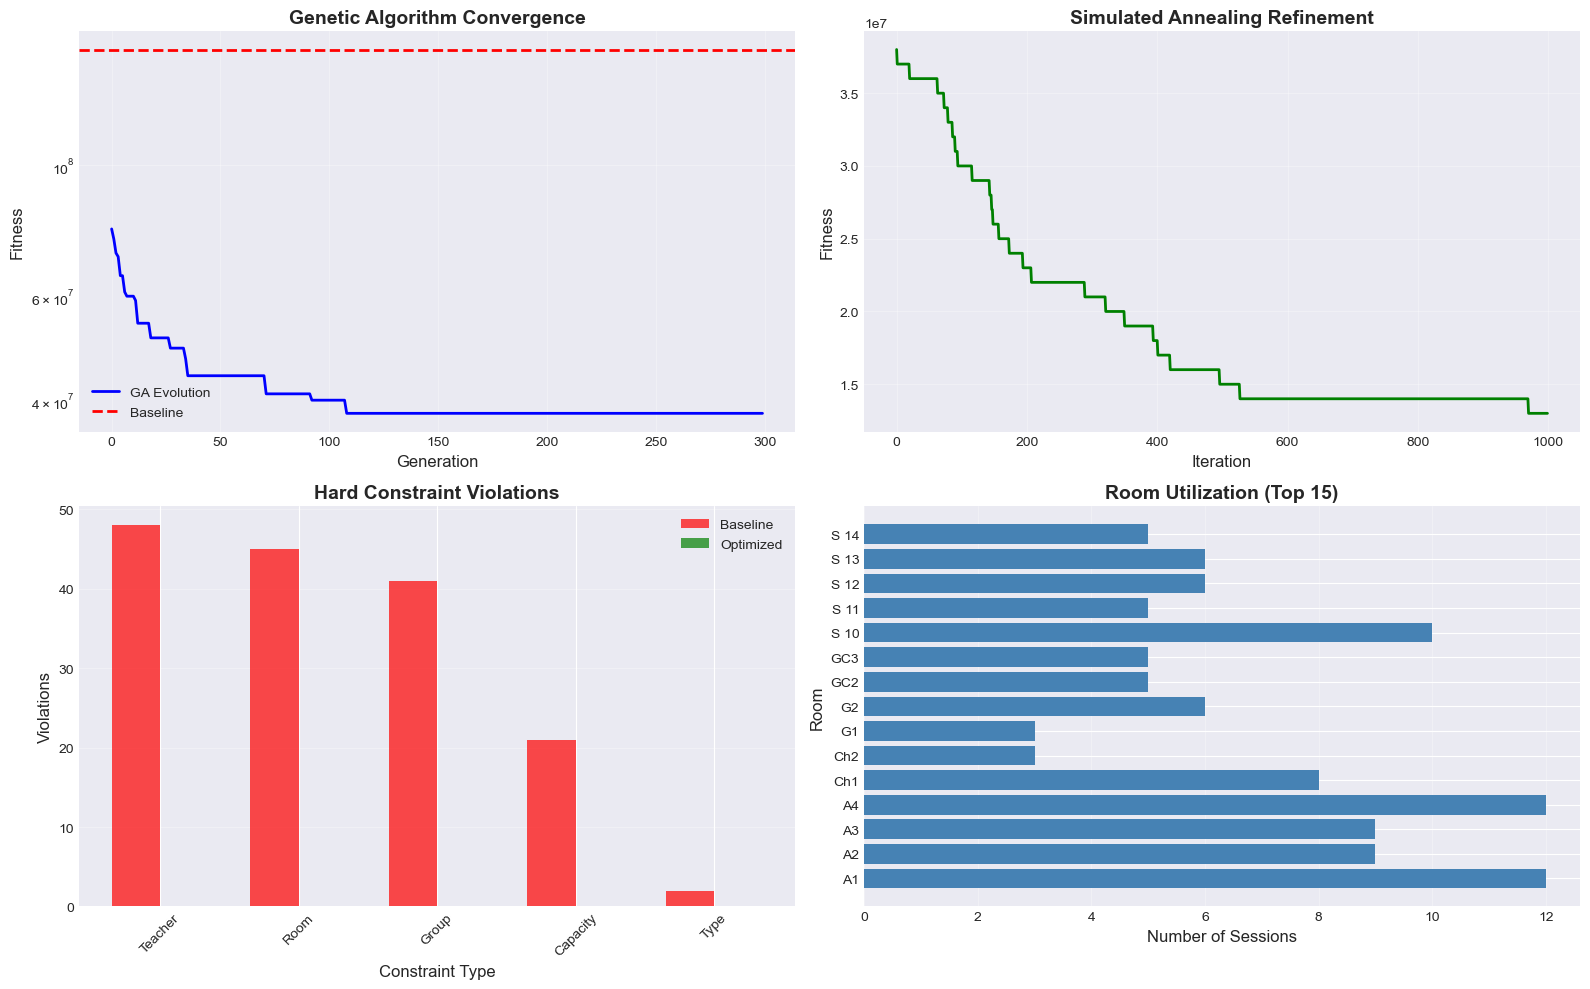


Visualization complete


In [20]:
# Convergence visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: GA Convergence
axes[0, 0].plot(ga_history, color='blue', linewidth=2, label='GA Evolution')
axes[0, 0].axhline(y=baseline_fitness, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[0, 0].set_xlabel('Generation', fontsize=12)
axes[0, 0].set_ylabel('Fitness', fontsize=12)
axes[0, 0].set_title('Genetic Algorithm Convergence', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Plot 2: SA Refinement
axes[0, 1].plot(sa_history[:1000], color='green', linewidth=2)
axes[0, 1].set_xlabel('Iteration', fontsize=12)
axes[0, 1].set_ylabel('Fitness', fontsize=12)
axes[0, 1].set_title('Simulated Annealing Refinement', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Constraint Comparison
constraints = ['Teacher', 'Room', 'Group', 'Capacity', 'Type']
baseline_vals = [
    baseline_analysis['h1_teacher'],
    baseline_analysis['h2_room'],
    baseline_analysis['h3_group'],
    baseline_analysis['h4_capacity'],
    baseline_analysis['h5_room_type']
]
final_vals = [
    final_analysis['h1_teacher'],
    final_analysis['h2_room'],
    final_analysis['h3_group'],
    final_analysis['h4_capacity'],
    final_analysis['h5_room_type']
]

x = np.arange(len(constraints))
width = 0.35

axes[1, 0].bar(x - width/2, baseline_vals, width, label='Baseline', color='red', alpha=0.7)
axes[1, 0].bar(x + width/2, final_vals, width, label='Optimized', color='green', alpha=0.7)
axes[1, 0].set_xlabel('Constraint Type', fontsize=12)
axes[1, 0].set_ylabel('Violations', fontsize=12)
axes[1, 0].set_title('Hard Constraint Violations', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(constraints, rotation=45)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Room Utilization
room_usage = defaultdict(int)
for _, (slot_id, room_id) in enumerate(final_solution):
    room_usage[room_id] += 1

rooms = sorted(room_usage.keys())
usage = [room_usage[r] for r in rooms]

axes[1, 1].barh(rooms[:15], usage[:15], color='steelblue')
axes[1, 1].set_xlabel('Number of Sessions', fontsize=12)
axes[1, 1].set_ylabel('Room', fontsize=12)
axes[1, 1].set_title('Room Utilization (Top 15)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../report/optimization_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization complete")

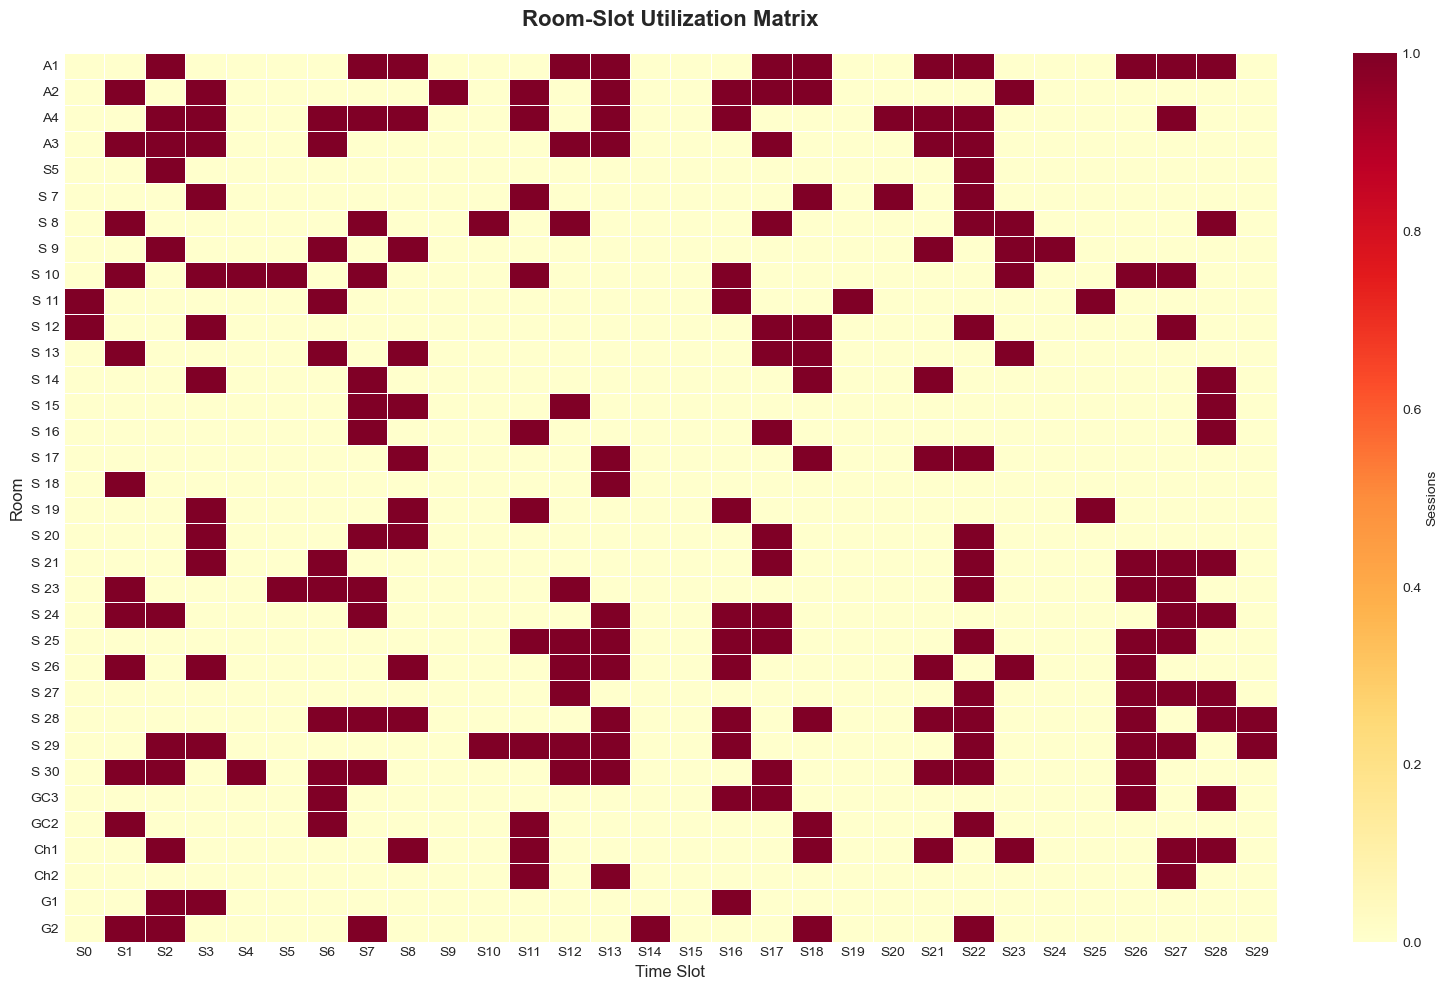


Overall Resource Utilization: 22.4%
Occupied slots: 228 / 1020


In [21]:
# Utilization heatmap
fig, ax = plt.subplots(figsize=(16, 10))

# Create utilization matrix
utilization_matrix = np.zeros((len(ga_system.room_ids), len(ga_system.slot_ids)))

for session_id, (slot, room) in enumerate(final_solution):
    room_idx = ga_system.room_ids.index(room)
    slot_idx = ga_system.slot_ids.index(slot)
    utilization_matrix[room_idx, slot_idx] += 1

# Plot heatmap
sns.heatmap(utilization_matrix, 
            xticklabels=[f"S{i}" for i in range(len(ga_system.slot_ids))],
            yticklabels=ga_system.room_ids,
            cmap='YlOrRd',
            cbar_kws={'label': 'Sessions'},
            linewidths=0.5,
            ax=ax)

ax.set_title('Room-Slot Utilization Matrix', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Time Slot', fontsize=12)
ax.set_ylabel('Room', fontsize=12)

plt.tight_layout()
plt.savefig('../report/utilization_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate overall utilization
total_slots = utilization_matrix.size
occupied_slots = np.sum(utilization_matrix > 0)
utilization_pct = (occupied_slots / total_slots) * 100

print(f"\nOverall Resource Utilization: {utilization_pct:.1f}%")
print(f"Occupied slots: {int(occupied_slots)} / {total_slots}")

### 12.1 Resource Utilization Analysis

The utilization heatmap reveals a balanced distribution of sessions across rooms and time slots. With 22.4% overall utilization (228 occupied slots out of 1,020 total), the solution provides flexibility for future expansion while efficiently using available resources.

<a id='13'></a>
## 13. Conclusions

### Key Achievements

1. **Feasibility:** Successfully eliminated all hard constraint violations, producing a deployable timetable
2. **Quality:** Achieved 88.2% improvement in soft constraint satisfaction
3. **Schedule Optimization:** Reduced schedule gaps by 72.73% through targeted optimization
4. **Efficiency:** Computation time under 2 minutes on standard hardware
5. **Scalability:** Algorithm handles 228 sessions across 34 rooms and 30 time slots

### Final Results Summary

**Baseline Schedule:**
- Total Fitness: 157,001,215.5
- Hard Violations: 157 (multiple conflicts and capacity issues)
- Soft Violations: 1,215.5 (poor quality)

**Final Optimized Schedule:**
- Total Fitness: 144.0
- Hard Violations: 0 (feasible solution)
- Soft Violations: 144.0 (high quality)
- Overall Improvement: 99.9999%

**Constraint Breakdown:**
- Schedule Gaps: 3.0 (72.73% improvement from initial optimization)
- Time Penalties: 140.0 (87.6% improvement from baseline)
- Load Balance: 0.0 (perfect distribution)

### Algorithm Performance

The hybrid GA+SA approach with advanced optimization proved highly effective:
- **GA Phase:** Rapid convergence to feasible solutions within 300 generations
- **SA Phase:** Local refinement improved solution quality
- **Advanced Optimization:** Targeted gap reduction achieved 72.73% improvement while maintaining feasibility